# Importing Modules

In [219]:
import numpy as np
from matplotlib import pyplot as plt

# General Utilities

#### Input:  The images & their titles; others configurations are optional
#### Description: Since we'll be previewing alot of images (it's a computer vision course), it's quite handy to have a rendering function

In [220]:
def RenderImages(images: list, titles: list, nrows = 1, ncols = 3, figsize = (36, 48), cmap = 'gray') -> None:
    plt.subplots(nrows = nrows, ncols = ncols, figsize = figsize)
    for i in range(len(images)):
        plt.subplot(nrows, ncols, (i + 1))
        plt.title(titles[i])
        plt.imshow(images[i], cmap = cmap)

# Part I 

## Transform Image

#### Input: Image 2D array & Color Weights (optional), by default is set to the weights of the specified rule
#### Output: A 2D array representing the greyscale version of the image
#### Description: Converting colored data to greyscale according to: 
$$I_{grey}(p) = 0.3 \times I_{red}(p) + 0.59 \times I_{green}(p) + 0.11 \times I_{blue}(p)$$

In [221]:
def TransformImage(image: np.ndarray, colorWeights = [0.3, 0.59, 0.11]) -> np.ndarray:
    return image.dot(colorWeights)

## Calculate Integral Image

#### Input:       2D array representing the image
#### Output:      2D array representing the integral image
#### Description: The implementation is done in two loops (i.e. steps); integrate the rows then integrate the columns

In [222]:
def CalculateIntegral(image: np.ndarray) -> np.ndarray:
    return image.cumsum(axis = 0).cumsum(axis = 1)

## Calculate Local Sum

#### Input:  An integral image, and a pair of coordinates $( p_0 = (x_0, y_0), p_1 = (x_1, y_1) )$
#### Output: The local sum for the rectangular area defined by the pair of points

NO LOGICAL CHECKS ARE PERFORMED. THE USER HAS TO SET THE FIRST POINT TO BE THE UPPER LEFT & THE SECOND TO BE THE LOWER LEFT

In [223]:
def CalculateLocalSum(integralImage: np.ndarray, point1: tuple[float, float], point2: tuple[float, float]) -> float:
    return (integralImage[int(point1[0]), int(point1[1])] + integralImage[int(point2[0]), int(point2[1])]) - (integralImage[int(point2[0]), int(point1[1])] + integralImage[int(point1[0]), int(point2[1])])

# Part II

## Detect Eyes

#### Input:       The Integral image & the kernel width ($n$)
#### Output:      The coordinates which represent the maximum score achieved after convluting the kernel.
#### Description: Calculate the kernel value for each feasible point on the integral image, according the kernel values

| Region   | Points             | $P_i$                | $P_j$               |
|----------|--------------------|----------------------|---------------------|
| $LS_1$   | $(P_1,    P_2   )$ | $(-0.5n  , -0.075n)$ | $(-0.05n , 0     )$ |
| $LS_2$   | $(P_3,    P_4   )$ | $(-0.5n  ,       0)$ | $(-0.05n , 0.075n)$ |
| $LS_3$   | $(P_5,    P_6   )$ | $(0.05n  , -0.075n)$ | $(0.5n   , 0     )$ |
| $LS_4$   | $(P_7,    P_8   )$ | $(0.05n  ,       0)$ | $(0.5n   , 0.075n)$ |
| $LS_5$   | $(P_9,    P_{10})$ | $(-0.325n,  0.125n)$ | $(-0.225n,   0.3n)$ |
| $LS_6$   | $(P_{11}, P_{12})$ | $(-0.1n  ,  0.125n)$ | $(0.1n   ,   0.3n)$ |
| $LS_7$   | $(P_{13}, P_{14})$ | $(0.225n ,  0.125n)$ | $(0.325n ,   0.3n)$ |

Note: point values are relative to the center point (0, 0)

##### Kernel Values $V$ at point $x$ is:
$$V|_x = (LS_1|_x + LS_3|_x + LS_6|_x) - (LS_2|_x + LS_4|_x + LS_5|_x + LS_7|_x)$$

In [224]:
def DetectEye(integeralImage: np.ndarray, n: int) -> tuple[int, int]:
    max   = -1
    index = (-1, -1)
    height, width = integeralImage.shape

    for i in range(int(np.ceil(n * 0.075)), height - int(np.floor(n * 0.3))):
        for j in range(int(np.ceil(n * 0.5)), width - int(np.floor(n * 0.5))):
            Ls_1 = CalculateLocalSum(integeralImage, (i - 0.075 * n, j - 0.5   * n), (i            , j - 0.05  * n))
            Ls_2 = CalculateLocalSum(integeralImage, (i            , j - 0.5   * n), (i + 0.075 * n, j - 0.05  * n))
            Ls_3 = CalculateLocalSum(integeralImage, (i - 0.075 * n, j + 0.05  * n), (i            , j + 0.5   * n))
            Ls_4 = CalculateLocalSum(integeralImage, (i            , j + 0.05  * n), (i + 0.075 * n, j + 0.5   * n))
            Ls_5 = CalculateLocalSum(integeralImage, (i + 0.125 * n, j - 0.325 * n), (i + 0.3   * n, j - 0.225 * n))
            Ls_6 = CalculateLocalSum(integeralImage, (i + 0.125 * n, j - 0.1   * n), (i + 0.3   * n, j + 0.1   * n))
            Ls_7 = CalculateLocalSum(integeralImage, (i + 0.125 * n, j + 0.225 * n), (i + 0.3   * n, j + 0.325 * n))

            localMax = (Ls_1 + Ls_3 + Ls_6) - (Ls_2 + Ls_4 + Ls_5 + Ls_7)

            if localMax > max:
                max = localMax
                index = (i, j)

    return index

## Extract Detected Eye

#### Input:  The Images itself, the maximum position retrieved from DetectEye function & the kernel width.
#### Output: 2D array representing the drawn image
#### Description: Retrieved a masked version of the original, that only contians the human eye

In [225]:
def ExtractDetectedEye(image: np.ndarray, maximumIndex: tuple[int, int], kernelWidth: int) -> np.ndarray:
    mask = np.zeros(image.shape) 

    mask[maximumIndex[0] - int(0.075 * kernelWidth) : maximumIndex[0] + int(0.3 * kernelWidth), 
         maximumIndex[1] - int(0.5   * kernelWidth) : maximumIndex[1] + int(0.5 * kernelWidth)] = 1

    return image * mask

# Part III - Putting Everything together

## Importing Image Samples

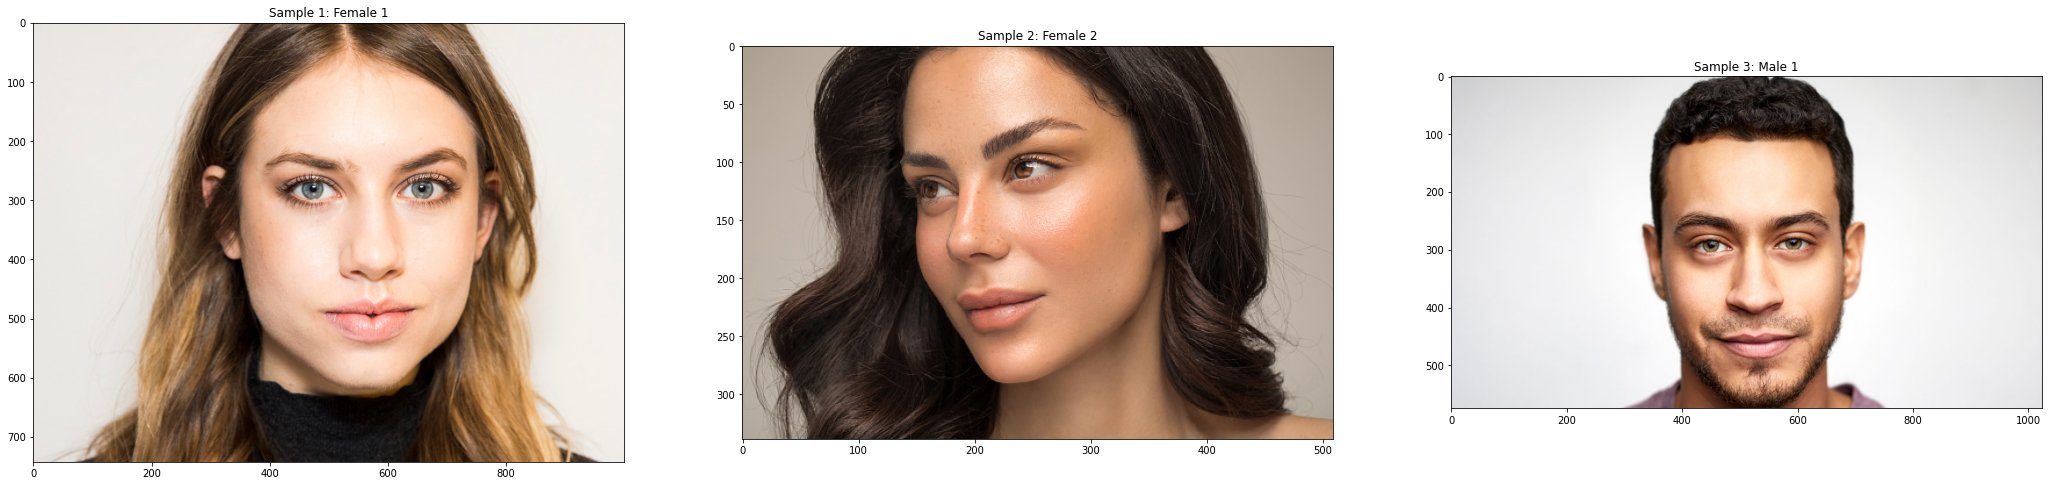

In [226]:
image_female_1 = np.array(plt.imread('Samples/f2.png'))
image_female_2 = np.array(plt.imread('Samples/f6.jpg'))
image_male_1   = np.array(plt.imread('Samples/f3.jpg'))

RenderImages([image_female_1, image_female_2, image_male_1], ['Sample 1: Female 1', 'Sample 2: Female 2', 'Sample 3: Male 1'])

## Transforming Images to Greyscale

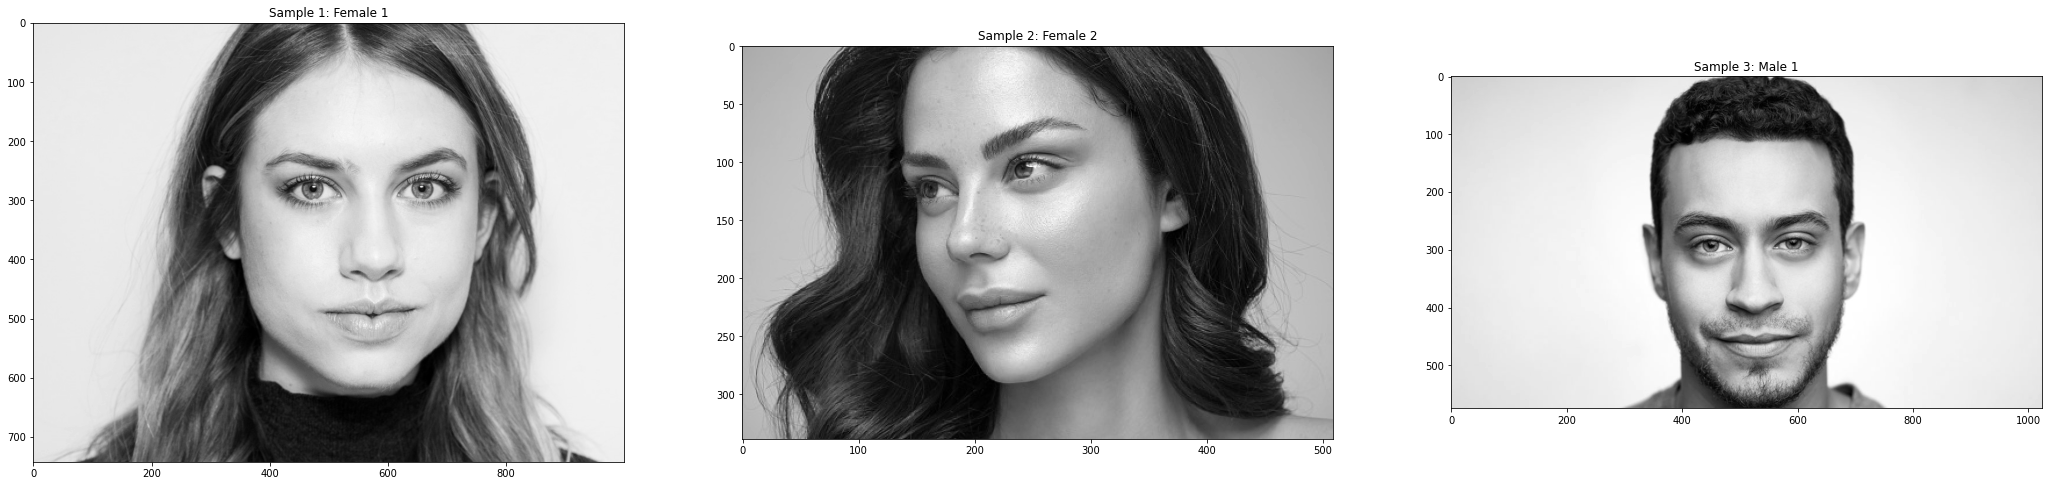

In [227]:
image_grey_female_1 = TransformImage(image_female_1)
image_grey_female_2 = TransformImage(image_female_2)
image_grey_male_1   = TransformImage(image_male_1)

RenderImages([image_grey_female_1 , image_grey_female_2 , image_grey_male_1], 
             ['Sample 1: Female 1', 'Sample 2: Female 2', 'Sample 3: Male 1'])

## Calculating the Integral Image

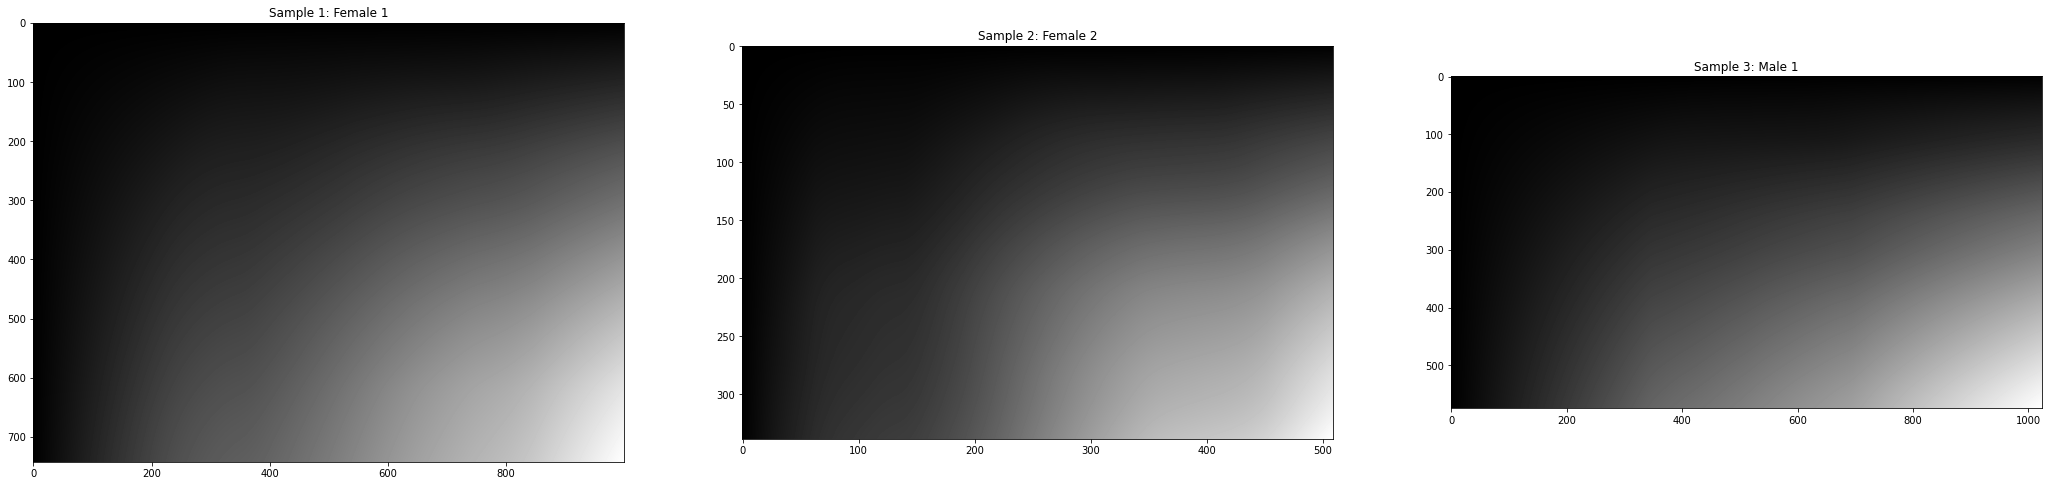

In [228]:
image_integral_female_1 = CalculateIntegral(image_grey_female_1)
image_integral_female_2 = CalculateIntegral(image_grey_female_2)
image_integral_male_1   = CalculateIntegral(image_grey_male_1)

RenderImages([image_integral_female_1, image_integral_female_2, image_integral_male_1],
             ['Sample 1: Female 1'   , 'Sample 2: Female 2'   , 'Sample 3: Male 1'   ])

## Detecting Eyes

Sample 1 - Female 1 eye index: (219, 566) 
Sample 2 - Female 2 eye index: (89, 201) 
Sample 3 - Male 1 eye index: (241, 523)


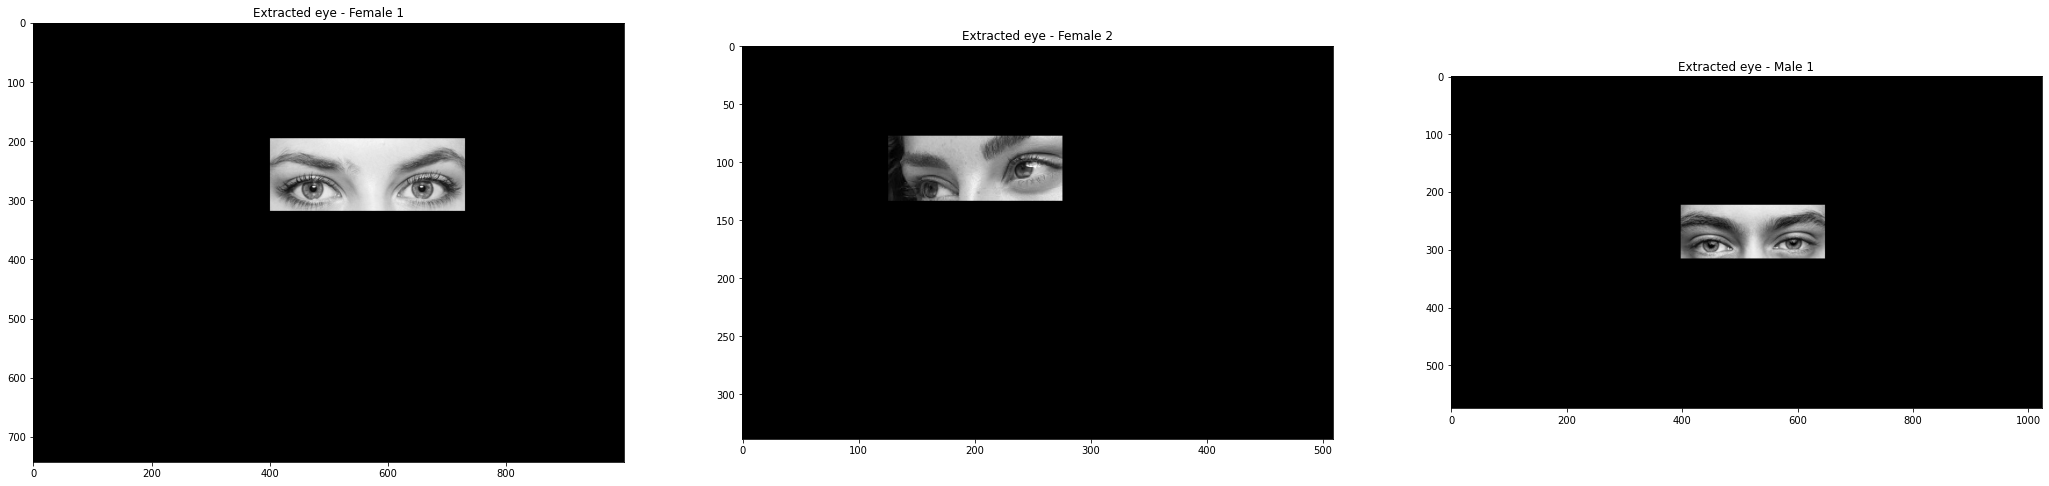

In [229]:
female_eye_index_1 = DetectEye(image_integral_female_1, 330)
female_eye_index_2 = DetectEye(image_integral_female_2, 150)
male_eye_index_1   = DetectEye(image_integral_male_1  , 250)

female_eye_1 = ExtractDetectedEye(image_grey_female_1, female_eye_index_1, 330)
female_eye_2 = ExtractDetectedEye(image_grey_female_2, female_eye_index_2, 150)
male_eye_1   = ExtractDetectedEye(image_grey_male_1  , male_eye_index_1  , 250)

print('Sample 1 - Female 1 eye index:', female_eye_index_1, 
      '\nSample 2 - Female 2 eye index:', female_eye_index_2, 
      '\nSample 3 - Male 1 eye index:'  , male_eye_index_1   )
RenderImages([female_eye_1              , female_eye_2              , male_eye_1              ], 
             ['Extracted eye - Female 1', 'Extracted eye - Female 2', 'Extracted eye - Male 1'])
